In [2]:
from PIL import Image
import matplotlib.pyplot as plt 
import numpy as np
import time

import torch
import torch.nn
import torch.optim as optim
from torchvision import transforms, models

import HRNet
import utils
from glob import glob
import os

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('------------------------------------------------------------------')
print(device)
print('------------------------------------------------------------------')
# get the VGG19's structure except the full-connect layers
VGG = models.vgg19(pretrained=True).features
VGG.to(device)
# print(VGG)
# only use VGG19 to extract features, we don't need to change it's parameters
for parameter in VGG.parameters():
    parameter.requires_grad_(False)

    

------------------------------------------------------------------
cuda
------------------------------------------------------------------


In [22]:
contents = glob("../../input/contents/*")
styles = glob("../../input/styles/*")
image_path = styles[0]
style_image = utils.load_image(image_path, img_size=500)  # temporary/style.png
style_image = style_image.to(device)
imarray = np.random.rand(500,500,3) * 255
im = Image.fromarray(imarray.astype('uint8')).convert('RGB')
rand_image_path  = "tmp.jpg"
im.save(rand_image_path)
# rand_image = torch.rand((1,3,500,500))
rand_image = utils.load_image(rand_image_path,img_size=500)
rand_image = rand_image.to(device)
style_image.shape,rand_image.shape

(torch.Size([1, 3, 500, 500]), torch.Size([1, 3, 500, 500]))

In [28]:
styles

['../../input/styles/frozen.jpg',
 '../../input/styles/pencil.jpg',
 '../../input/styles/style11.jpg',
 '../../input/styles/rickmortyhouse.jpg',
 '../../input/styles/rmcitadel.jpg',
 '../../input/styles/style4.jpg',
 '../../input/styles/style12.jpg',
 '../../input/styles/night.jpg',
 '../../input/styles/ppuff.jpg',
 '../../input/styles/sunset.jpg',
 '../../input/styles/style3.jpg',
 '../../input/styles/style.jpg',
 '../../input/styles/vitruvian.jpg',
 '../../input/styles/style10.jpg']

In [25]:
style_vgg_feats = utils.get_features(style_image, VGG)
rand_vgg_feats = utils.get_features(rand_image, VGG)
style_gram_matrixs = {layer: utils.get_grim_matrix(style_vgg_feats[layer]) for layer in style_vgg_feats}
style_vgg_feats.keys()

dict_keys(['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv4_2', 'conv5_1'])

conv1_1


/home/appuser/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/home/appuser/.local/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


After 500 criterions:
Style loss:  0.07308359444141388


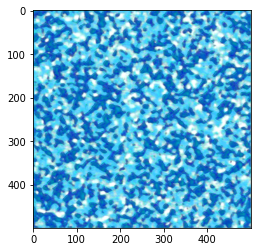

conv2_1
After 500 criterions:
Style loss:  0.34982621669769287


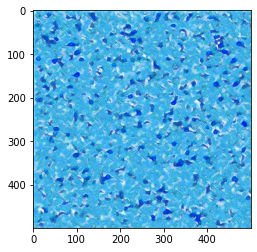

conv3_1
After 500 criterions:
Style loss:  5.308021545410156


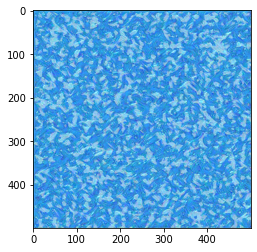

conv4_1
After 500 criterions:
Style loss:  0.18776345252990723


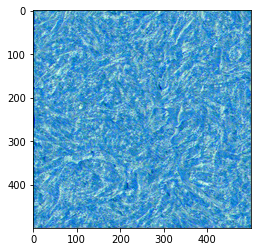

conv5_1
After 500 criterions:
Style loss:  0.0025180468801409006


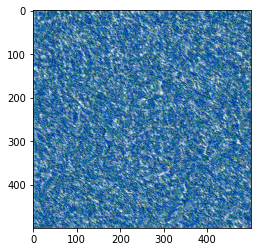

In [27]:
style_weights = {'conv1_1': 0.1,
                'conv2_1': 0.2,
                'conv3_1': 0.4,
                'conv4_1': 0.8,
                'conv5_1': 1.6}
for layer in style_weights: 
    print(layer)               
    style_net = models.TransformationNet()
    style_net.to(device)
    show_every = 100
    optimizer = optim.Adam(style_net.parameters(), lr=5e-3)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.9)
    steps = 500

    for epoch in range(steps+1):
        scheduler.step()

        target = style_net(rand_image).to(device)
        target.requires_grad_(True)
        target_features = utils.get_features(target, VGG) 

            
        target_feature = target_features[layer]  # output image's feature map after layer
        target_gram_matrix = utils.get_grim_matrix(target_feature)
        style_gram_matrix = style_gram_matrixs[layer]

        layer_style_loss = style_weights[layer] * torch.mean((target_gram_matrix - style_gram_matrix) ** 2)
        b, c, h, w = target_feature.shape
        style_loss = layer_style_loss / (c * h * w)
        optimizer.zero_grad()
        style_loss.backward()
        optimizer.step()
        # if epoch % show_every == 0:
            # print("After %d criterions:" % epoch)
            # print('Style loss: ', style_loss.item())
            # plt.imshow(utils.im_convert(target))
            # plt.show()
    print("After %d criterions:" % epoch)
    print('Style loss: ', style_loss.item())
    plt.imshow(utils.im_convert(target))
    plt.show()

In [50]:
contents = glob("../../input/contents/*")
styles = glob("../../input/styles/*")
image_path = contents[-2]
content_image = utils.load_image(image_path, img_size=500)  # temporary/style.png
content_image = content_image.to(device)
imarray = np.random.rand(500,500,3) * 255
# imarray = np.random.uniform(-90., 90., (500,500,3)).astype(np.float32) 
imarray = np.random.normal(loc=100, scale=50., size=(500,500,3)).astype(np.float32)
# imarray = np.zeros((500,500,3),dtype=np.float32)
im = Image.fromarray(imarray.astype('uint8')).convert('RGB')
rand_image_path  = "tmp.jpg"
im.save(rand_image_path)
# rand_image = torch.rand((1,3,500,500))
rand_image = utils.load_image(rand_image_path,img_size=500)
rand_image = rand_image.to(device)
content_image.shape,rand_image.shape
contents

['../../input/contents/burjkalifa.jpg',
 '../../input/contents/future.jpg',
 '../../input/contents/frame.jpg',
 '../../input/contents/content.jpg',
 '../../input/contents/wheel.jpg']

After 0 criterions:
Content loss:  11.402318954467773


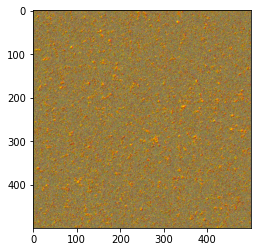

After 1000 criterions:
Content loss:  0.6971920132637024


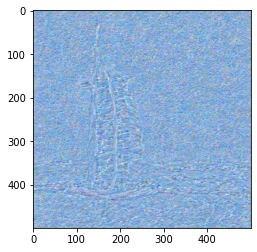

After 2000 criterions:
Content loss:  0.5122093558311462


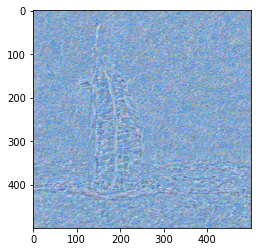

After 3000 criterions:
Content loss:  0.44195711612701416


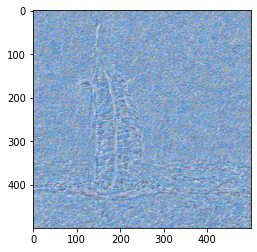

After 4000 criterions:
Content loss:  0.41053852438926697


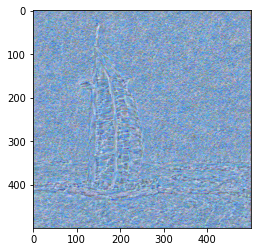

After 5000 criterions:
Content loss:  0.40142861008644104


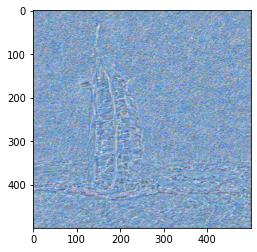

After 6000 criterions:
Content loss:  0.39681440591812134


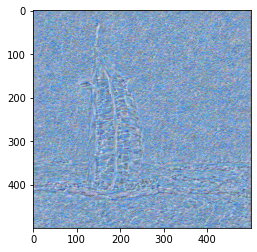

After 7000 criterions:
Content loss:  0.39470237493515015


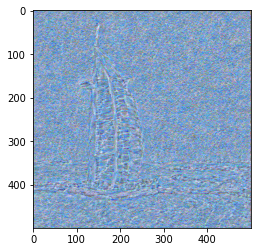

After 8000 criterions:
Content loss:  0.3937211036682129


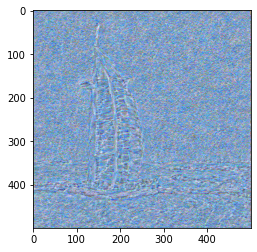

After 9000 criterions:
Content loss:  0.39312705397605896


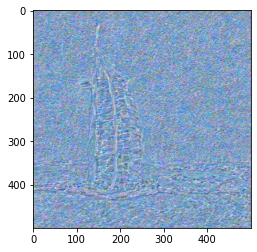

After 10000 criterions:
Content loss:  0.3927780091762543


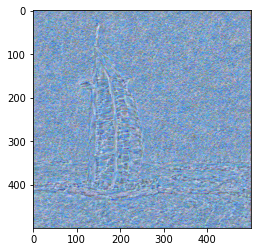

After 10000 criterions:
Content loss:  0.3927780091762543


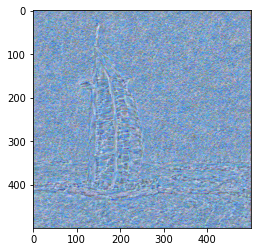

In [52]:
           
style_net = HRNet.HRNet()
style_net.to(device)
content_features = utils.get_features(content_image, VGG)
show_every = 1000
steps = 10000
optimizer = optim.Adam(style_net.parameters(), lr=5e-3)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.9)


for epoch in range(steps+1):
    scheduler.step()

    target = style_net(rand_image).to(device)
    target.requires_grad_(True)

    target_features = utils.get_features(target, VGG) 
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)
        
    optimizer.zero_grad()
    content_loss.backward()
    optimizer.step()
    if epoch % show_every == 0:
        print("After %d criterions:" % epoch)
        print('Content loss: ', content_loss.item())
        plt.imshow(utils.im_convert(target))
        plt.show()
print("After %d criterions:" % epoch)
print('Content loss: ', content_loss.item())
plt.imshow(utils.im_convert(target))
plt.show()

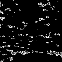

In [19]:
# torch.Size([1, 512, 62, 62])
import PIL
# PIL.Image.fromarray(content_features['conv4_2'].detach().cpu().numpy()[0][0])
PIL.Image.fromarray(np.uint8(content_features['conv4_2'].detach().cpu().numpy()[0][1]*255))